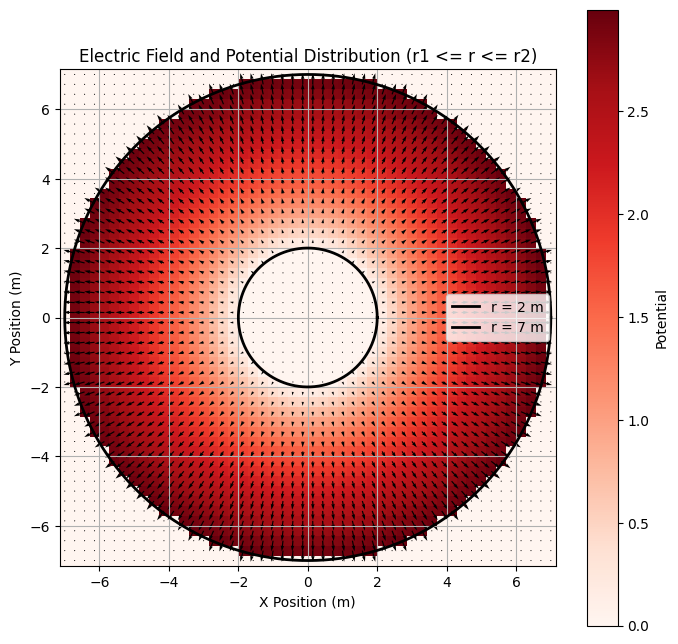

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r1 = 2  # Inner radius for the potential region
r2 = 7  # Outer radius for the potential region
V = 3   # Potential scaling constant
num_points = 100  # Number of random points to generate

# Generate random points in Cartesian coordinates
x_rand = np.random.uniform(-r2, r2, num_points)
y_rand = np.random.uniform(-r2, r2, num_points)

# Calculate the radial distance (r) for each random point
r_rand = np.sqrt(x_rand**2 + y_rand**2)  # r = sqrt(x^2 + y^2)

# Mask: Only consider points where r1 <= r <= r2
mask = (r_rand >= r1) & (r_rand <= r2)

# Apply the mask to filter valid points
x_valid = x_rand[mask]
y_valid = y_rand[mask]
r_valid = r_rand[mask]

# Set up a meshgrid for the plot (to represent the full region)
x_vals = np.linspace(-r2, r2, 50)
y_vals = np.linspace(-r2, r2, 50)
x, y = np.meshgrid(x_vals, y_vals)

# Calculate the radial distance for each point on the grid
r = np.sqrt(x**2 + y**2)

# Mask the region where r is between r1 and r2 (valid points for calculation)
mask_grid = (r >= r1) & (r <= r2)

# Initialize the potential and electric field arrays
pot = np.zeros_like(x)
u = np.zeros_like(x)
v = np.zeros_like(y)

# Loop over each point on the grid and calculate the potential and electric field
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        if mask_grid[j, i]:  # Only process points where r1 <= r <= r2
            r_ij = r[j, i]  # Radial distance at grid point
            theta = np.arctan2(y[j, i], x[j, i])  # Polar angle at grid point

            # Electric field (radial component) using the potential gradient
            E_r = V / np.log(r2 / r1) * r_ij

            # Convert the radial electric field to Cartesian components (u, v)
            u[j, i] = E_r * np.cos(theta)  # x-component of electric field
            v[j, i] = E_r * np.sin(theta)  # y-component of electric field

            # Potential calculation at the grid point
            pot[j, i] = (V * np.log(r1) - V * np.log(r_ij)) / (np.log(r1) - np.log(r2))

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the potential using pcolormesh
plt.pcolormesh(x, y, pot, shading='auto', cmap="Reds")
plt.colorbar(label="Potential")

# Add a circle at r1 and r2 (boundary of the region)
theta_circle = np.linspace(0, 2 * np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)
x_circle2 = r2 * np.cos(theta_circle)
y_circle2 = r2 * np.sin(theta_circle)

# Plot circles at r1 and r2
plt.plot(x_circle1, y_circle1, color='black', linewidth=2, label=f'r = {r1} m')
plt.plot(x_circle2, y_circle2, color='black', linewidth=2, label=f'r = {r2} m')

# Plot the electric field using quiver
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=50, color='black')

# Make the aspect ratio equal (circular plot)
plt.gca().set_aspect('equal', adjustable='box')

# Title and labels
plt.title("Electric Field and Potential Distribution (r1 <= r <= r2)")
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def analy( ymax, xmax, dxy, V, r1, r2):
    # Set up a meshgrid for the plot (to represent the full region)
    x_vals = np.arange(-xmax, xmax, dxy)
    y_vals = np.arange(-ymax, ymax, dxy)
    x, y = np.meshgrid(x_vals, y_vals)
    
    # Calculate the radial distance for each point on the grid
    r = np.sqrt(x**2 + y**2)
    
    # Mask the region where r is between r1 and r2 (valid points for calculation)
    mask_grid = (r >= r1) & (r <= r2)
    
    # Calculate potential for the valid points using vectorized operations
    pot = np.zeros_like(r)
    pot[mask_grid] = (V * np.log(r1) - V * np.log(r[mask_grid])) / (np.log(r1) - np.log(r2))
    
    return pot

def poisson( ymax, xmax, dxy, V, r1, r2):
    """Solve the Poisson equation with the given parameters using a finite difference method."""
    # Create the space grids
    x = np.arange(-xmax, xmax, dxy)
    y = np.arange(-ymax, ymax, dxy)
    X, Y = np.meshgrid(x, y)  # Create meshgrid for 2D space
    
    u = np.zeros_like(X)
    r = np.sqrt(X**2 + Y**2)

    def shape(grid, what, where, howbig, Volt, SmalorBig):
        if what == "circle":
            r = np.sqrt((X - where[0])**2 + (Y - where[1])**2)
            if SmalorBig == "small":
                grid[r < howbig[0]] = Volt
            if SmalorBig == "big":
                grid[r > howbig[0]] = Volt
    
    def bounds(grid):
        shape(grid, "circle", [0, 0], [r1], 0, "small")
        shape(grid, "circle", [0, 0], [r2], V, "big")
    
    bounds(u)  # Apply the boundary conditions initially
    
    # FTCS scheme for solving the Poisson equation (relaxed elliptical solver)
    diff = 1
    while diff > 1e-3:  # You can adjust the number of iterations as needed
        u_new = u.copy()

        # Vectorized update (avoids loops)
        u_new[1:-1, 1:-1] = 0.25 * (u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:])
        
        # Convergence check: Stop if the difference is small enough
        diff = np.max(np.abs(u_new - u))

        bounds(u_new)  # Apply the boundary conditions again after updating the grid
        u = u_new  # Update the solution
    
    return u

# Parameters
ymax = 10  # Maximum y value
xmax = 10  # Maximum x value
r1 = 2  # Inner radius for the potential region
r2 = 9  # Outer radius for the potential region
dxy = 0.1  # Grid resolution
V = 10

# Solve the Poisson equation
nupot = poisson( ymax, xmax, dxy, V, r1, r2)
analpot= analy( ymax, xmax, dxy, V, r1, r2)

# Calculate difference
ChangeInPot = np.abs(nupot - analpot)

# Plot the error
plt.figure(figsize=(10, 10))
plt.imshow(ChangeInPot, extent=(-xmax, xmax, -ymax, ymax), aspect='auto', cmap='Reds')

# Add circles at r1 and r2
theta_circle = np.linspace(0, 2 * np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)
x_circle2 = r2 * np.cos(theta_circle)
y_circle2 = r2 * np.sin(theta_circle)
    
plt.plot(x_circle1, y_circle1, color='black', linewidth=2, label=f'r = {r1} m')
plt.plot(x_circle2, y_circle2, color='black', linewidth=2, label=f'r = {r2} m')

plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Potential difference')
plt.title('Error between Numerical and Analytical Solution')
plt.show()

KeyboardInterrupt: 

/tmp/ipykernel_1495934/107517519.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, pot, shading='auto', cmap='inferno')


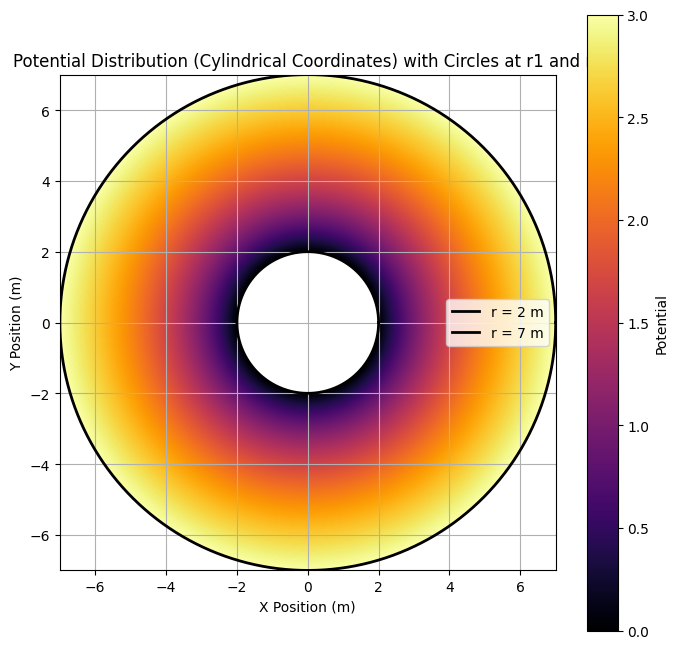

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r1 = 2
r2 = 7
V=3

r = np.linspace(r1, r2, 1000)  # radius from 0.1 to avoid log(0)
theta = np.linspace(0, 2*np.pi, 1000)  # full circle (0 to 2π radians)

# Create meshgrid for r and theta
R, Theta = np.meshgrid(r, theta)

# Convert polar to Cartesian coordinates (x, y)
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Potential calculation (Cylindrical Potential)
pot = (V * np.log(r1) - V * np.log(R)) / (np.log(r1) - np.log(r2))
#pot = V/np.log(r2/r1)*R

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the potential using pcolormesh for a smooth color representation
plt.pcolormesh(X, Y, pot, shading='auto', cmap='inferno')

# Add circles at r1 and r2
theta_circle = np.linspace(0, 2*np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)
x_circle2 = r2 * np.cos(theta_circle)
y_circle2 = r2 * np.sin(theta_circle)

# Plot circles at r1 and r2
plt.plot(x_circle1, y_circle1, color='black', linewidth=2, label=f'r = {r1} m')
plt.plot(x_circle2, y_circle2, color='black', linewidth=2, label=f'r = {r2} m')

# Make the aspect ratio equal (circular plot)
plt.gca().set_aspect('equal', adjustable='box')

# Title and labels
plt.title("Potential Distribution (Cylindrical Coordinates) with Circles at r1 and r2")
plt.colorbar(label='Potential')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_1495934/1814799917.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


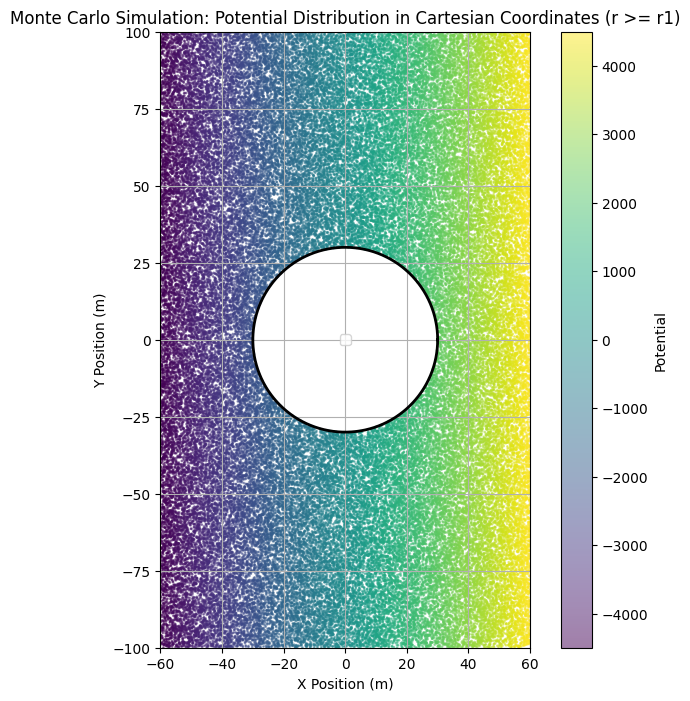

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r1 = 30
d = 60
num_points = 100000  # Number of random points to generate

# Generate random x and y values within a defined range
x_vals = np.random.uniform(-d,d, num_points)
y_vals = np.random.uniform(-100, 100, num_points)

# Create empty lists to store values for plotting
valid_x = []
valid_y = []
valid_pot_vals = []

# Loop through the generated points and apply the condition r >= r1
for x, y in zip(x_vals, y_vals):
    r = np.sqrt(x**2 + y**2)  # Calculate radial distance
    if r >= r1:  # Ignore points where r < r1
        theta = np.arctan2(y, x)  # Calculate angle in polar coordinates
        pot = (r - r * r1**2) * (-5/d * np.cos(theta))  # Calculate potential
        
        # Append valid points to the lists
        valid_x.append(x)
        valid_y.append(y)
        valid_pot_vals.append(pot)

# Convert valid lists into numpy arrays for plotting
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)
valid_pot_vals = np.array(valid_pot_vals)

# Set up the plot
plt.figure(figsize=(8, 8))

# Plot the valid points in Cartesian coordinates (x, y) and color based on potential
scatter = plt.scatter(valid_x, valid_y, c=valid_pot_vals, cmap='viridis', s=1, alpha=0.5)

# Add a colorbar
plt.colorbar(scatter, label='Potential')

# Add circle at r1
theta_circle = np.linspace(0, 2*np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)

# Plot the circle at r1
plt.plot(x_circle1, y_circle1, color='black', linewidth=2,)


# Set axis limits
plt.xlim(-d, d)
plt.ylim(-100, 100)

# Make the aspect ratio equal (circular plot)
plt.gca().set_aspect('equal', adjustable='box')

# Title and labels
plt.title("Monte Carlo Simulation: Potential Distribution in Cartesian Coordinates (r >= r1)")
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')

# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_1495934/93478930.py:61: UserWarning: shading value 'edge' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(x, y, pot, shading='edge', cmap='PiYG')


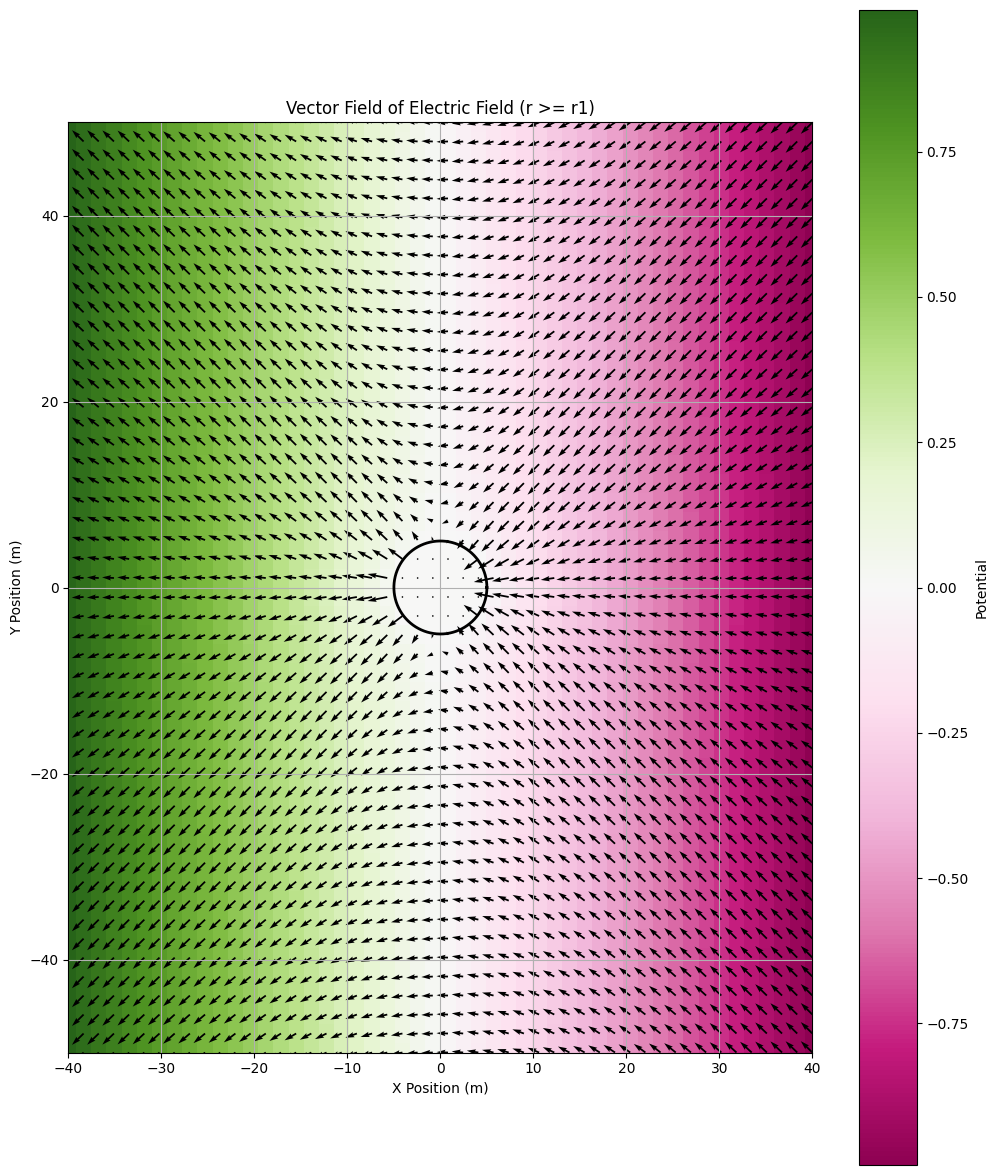

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r1 = 5  # Inner radius for the potential region
d = 40 # Grid limit for x and y
num_points = 50 # Number of points for the grid resolution
ymax=50

# Generate a grid of x and y values for the vector field
x_vals = np.linspace(-d, d, num_points)
y_vals = np.linspace(-ymax, ymax, num_points)

# Create meshgrid for plotting
x, y = np.meshgrid(x_vals, y_vals)

# Calculate the radial distance from the origin
r = np.sqrt(x**2 + y**2)

# Only keep values where r >= r1 (mask the region inside r1)
mask = r >= r1

# Initialize the components of the vector field (u and v)
u = np.zeros_like(x)
v = np.zeros_like(y)

# Compute the electric field components only for points where r >= r1
V = 1  # Potential scaling constant (set appropriately for your problem)
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        if mask[j, i]:  # Only process points where r >= r1
            r_ij = r[j, i]
            theta = np.arctan2(y[j, i], x[j, i])  # Angle for polar coordinates

            # Radial component (dV/dr)
            dV_dr = (V/d)*(np.cos(theta)*(r1**2)/r_ij**2 + np.cos(theta))

            # Angular component (dV/dtheta)
            dV_dtheta = (V/d)*(np.sin(theta)*(r1**2)/r_ij**2 - np.sin(theta))

            # Convert the polar electric field components to Cartesian components
            u[j, i] = -dV_dr * np.cos(theta) + dV_dtheta * np.sin(theta)
            v[j, i] = -dV_dr * np.sin(theta) + dV_dtheta * np.cos(theta)

# Now, let's calculate the potential based on the mask condition
pot = np.zeros_like(x)  # Initialize the potential array with zeros

# Loop over each point to apply the mask and calculate the potential
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        if mask[j, i]:  # Only calculate potential where r >= r1
            r_ij = r[j, i]
            theta = np.arctan2(y[j, i], x[j, i])  # Angle for polar coordinates
            # Calculate potential based on your formula
            pot[j, i] = (r_ij - (r_ij**-1) * r1**2) * (-V/d * np.cos(theta))

# Plotting the results
plt.figure(figsize=(12, 15))

# Plot the potential using pcolormesh
plt.pcolormesh(x, y, pot, shading='edge', cmap='PiYG')
plt.colorbar(label="Potential")

# Plot the vector field using quiver
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=.02, color='black')

# Add a circle at r1 (boundary of the region where r >= r1)
theta_circle = np.linspace(0, 2 * np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)

# Plot the circle at r1
plt.plot(x_circle1, y_circle1, color='black', linewidth=2)

# Set axis limits
plt.xlim(-d, d)
plt.ylim(-ymax, ymax)

# Make the aspect ratio equal (circular plot)
plt.gca().set_aspect('equal', adjustable='box')

# Title and labels
plt.title("Vector Field of Electric Field (r >= r1)")
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')

# Add grid for better visualization
plt.grid(True)

# Show the plot
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image 
from mpl_toolkits.mplot3d import Axes3D

def possion(rmax,ymax,xmax,maxpoints,dxy):
    """COMMENTS
  
    """
    # Create thespace grids
    
    X = np.arange( xmax , xmax , dxy)
    y = np.arange( ymax, ymax , dxy)
    r = np.linespace( 0, rmax , maxpoints)
    theta = np.linespace( 0, np.pi , maxpoints)

    # Initialize the temperature array u (initial condition: u = 0 everywhere)
    u = np.zeros((len(x), len(y)))
    pot= np.zeros((len(x), len(y)))
    # Define the initial condition: constant heat source in the middle
   
    if np.sqrt(x**2+y**2)< r:
         u[x, y] = V # Set the initial heat source

    
    # Set the boundary conditions to 0 (open boundaries)
    
    
    u[:, 0] = V   # Left boundary
    u[:, -1] = -V  # Right boundary

    # FTCS scheme for time evolution
    for i,j in zip(x,y):  # relaxed eliptical
        pot[i,j]=((u[i+1,j]-2*u[x,y]+u[i-1,j])/(dxy**2))+u[i,j]-2*u[x,y+1]+u[u[i,j-1]/(dxy**2)

return pot , x, y 

SyntaxError: invalid syntax (706197022.py, line 36)

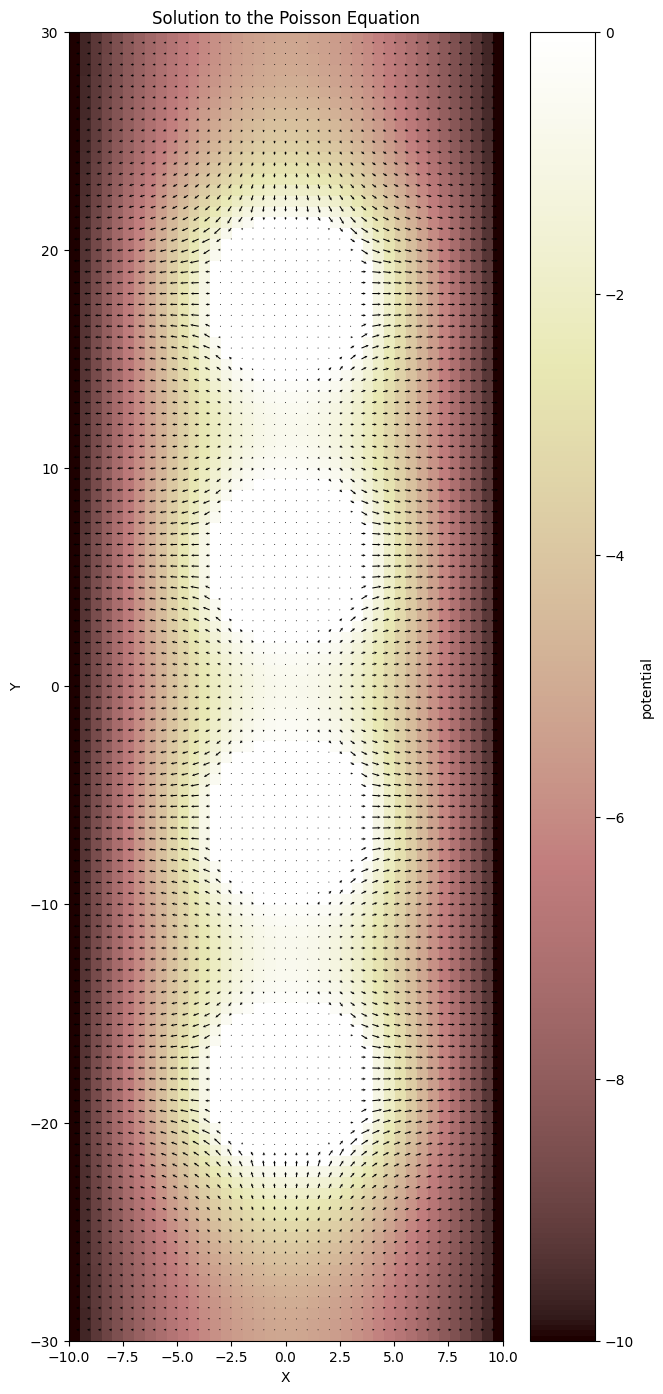

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

        

def poisson(rmax, ymax, xmax, maxpoints, dxy, V):
    """Solve the Poisson equation with the given parameters using a finite difference method."""
    # Create the space grids
    x = np.arange(-xmax, xmax, dxy)
    y = np.arange(-ymax, ymax, dxy)
    X, Y = np.meshgrid(x, y)  # Create meshgrid for 2D space
    
    u = np.zeros_like(X)
    r = np.sqrt((X-6)**2 + (Y+6)**2)

    def shape(grid,what,where,howbig,Volt):
        if what=="circle":
            r = np.sqrt((X-where[0])**2 + (Y-where[1])**2)
            grid[r < howbig[0]] = 0
        elif what=="rectangle":
            
            # Correcting the conditional slicing
            x_start = int(where[0] - howbig[0]/2)
            x_end = int(where[0] + howbig[0]/2)
            y_start = int(-where[1] - howbig[1]/2)
            y_end = int(-where[1] + howbig[1]/2)
            
            # Apply the mask inside the rectangle to set values to 0
            grid[(X >= x_start) & (X <= x_end) & (Y >= y_start) & (Y <= y_end)] = Volt
        
    # Apply initial conditions
    """def bounds(grid):
        
        #shape(grid,"circle or rectangle",[x,y],[width,height],volt)
        shape(grid,"rectangle",[0,12],[3,4],0)
        shape(grid,"rectangle",[0,4],[3,4],V)
        shape(grid,"rectangle",[0,-4],[3,4],-V)
        shape(grid,"rectangle",[0,-12],[3,4],0)
        
        grid[:, 0] = 0        # Left boundary
        grid[:, -1] = 0      # Right boundary
        
        # Update the top and bottom boundaries using neighboring points
        grid[(0,-1), 1:-1] = 0.25*(grid[(0,-1), 2:]+grid[(0,-1), :-2]+grid[(-1,-2), 1:-1]+grid[(1,0), 1:-1])"""
    def bounds(grid):
        
        #shape(grid,"circle or rectangle",[x,y],[width,height],volt)
        shape(grid,"circle",[0,18],[4],0)
        shape(grid,"circle",[0,6],[4],0)
        shape(grid,"circle",[0,-6],[4],0)
        shape(grid,"circle",[0,-18],[4],0)
        
        grid[:, 0] = -V        # Left boundary
        grid[:, -1] = -V      # Right boundary
        
        # Update the top and bottom boundaries using neighboring points
        grid[(0,-1), 1:-1] = 0.25*(grid[(0,-1), 2:]+grid[(0,-1), :-2]+grid[(-1,-2), 1:-1]+grid[(1,0), 1:-1])
      
    
    bounds(u)  # Apply the boundary conditions initially
    
    
    # FTCS scheme for solving the Poisson equation (relaxed elliptical solver)
    for _ in range(maxpoints):  # You can adjust the number of iterations as needed
        u_new = u.copy()  # Create a copy of u to avoid overwriting values during updates
        
        # Update the internal points (ignoring boundaries)
        for i in range(1, u.shape[0] - 1):
            for j in range(1, u.shape[1] - 1):
                u_new[i, j] = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1])

        
        
        # Convergence check: Stop if the difference is small enough
        diff = np.max(np.abs(u_new - u))
        if diff < 1e-23:
            break
        
        bounds(u_new)  # Apply the boundary conditions again after updating the grid
        u = u_new  # Update the solution
        
    return u, X, Y

# Parameters
rmax = 10   # Radius of internal region set to 0
ymax = 30  # Maximum y value
xmax = 10  # Maximum x value
maxpoints = 1000  # Number of iterations
dxy = 0.5  # Grid resolution
V = 10

# Solve the Poisson equation
pot, X, Y = poisson(rmax, ymax, xmax, maxpoints, dxy, V)

grad_x, grad_y = np.gradient(pot, axis=(1,0))

# Plot the result
plt.figure(figsize=(7,17))

plt.quiver(X, Y, -grad_x, -grad_y, scale=50 , headlength=3, headaxislength=2)
plt.imshow(pot, extent=(-xmax, xmax, -ymax, ymax), aspect='auto', cmap='pink')

plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='potential')
plt.title('Solution to the Poisson Equation')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


def poisson(rmax, ymax, xmax, maxpoints, dxy, V):
    """Solve the Poisson equation with the given parameters using a finite difference method."""
    # Create the space grids
    x = np.arange(-xmax, xmax, dxy)
    y = np.arange(-ymax, ymax, dxy)
    X, Y = np.meshgrid(x, y)  # Create meshgrid for 2D space
    
    u = np.zeros_like(X)
    
    def shape(grid, what, where, howbig, Volt):
        if what == "circle":
            r = np.sqrt((X - where[0])**2 + (Y - where[1])**2)
            grid[r < howbig[0]] = 0
        elif what == "rectangle":
            x_start = int(where[0] - howbig[0]/2)
            x_end = int(where[0] + howbig[0]/2)
            y_start = int(-where[1] - howbig[1]/2)
            y_end = int(-where[1] + howbig[1]/2)
            
            grid[(X >= x_start) & (X <= x_end) & (Y >= y_start) & (Y <= y_end)] = Volt
        
    def bounds(grid):
        shape(grid, "circle", [0, 18], [4], 0)
        shape(grid, "circle", [0, 6], [4], 0)
        shape(grid, "circle", [0, -6], [4], 0)
        shape(grid, "circle", [0, -18], [4], 0)
        
        grid[:, 0] = -V        # Left boundary
        grid[:, -1] = -V       # Right boundary
        grid[(0,-1), 1:-1] = 0.25*(grid[(0,-1), 2:]+grid[(0,-1), :-2]+grid[(-1,-2), 1:-1]+grid[(1,0), 1:-1])
        
    bounds(u)
    
    for _ in range(maxpoints):  
        u_new = u.copy()
        
        for i in range(1, u.shape[0] - 1):
            for j in range(1, u.shape[1] - 1):
                u_new[i, j] = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1])

        diff = np.max(np.abs(u_new - u))
        if diff < 1e-23:
            break
        
        bounds(u_new)
        u = u_new 
        
    return u, X, Y


class PoissonGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Poisson Equation Solver")
        self.colorbar=None

        # Create sliders and labels
        self.create_widgets()

    def create_widgets(self):
        # Grid resolution
        self.dxy_label = tk.Label(self.root, text="Grid Resolution (dxy):")
        self.dxy_label.grid(row=0, column=0)
        self.dxy_slider = tk.Scale(self.root, from_=0.1, to_=1.0, resolution=0.1, orient="horizontal")
        self.dxy_slider.set(0.5)
        self.dxy_slider.grid(row=0, column=1)

        # Max iterations
        self.maxpoints_label = tk.Label(self.root, text="Max Iterations:")
        self.maxpoints_label.grid(row=1, column=0)
        self.maxpoints_slider = tk.Scale(self.root, from_=100, to_=1000, orient="horizontal")
        self.maxpoints_slider.set(1000)
        self.maxpoints_slider.grid(row=1, column=1)

        # Potential Value
        self.V_label = tk.Label(self.root, text="Potential Value (V):")
        self.V_label.grid(row=2, column=0)
        self.V_slider = tk.Scale(self.root, from_=0, to_=50, orient="horizontal")
        self.V_slider.set(10)
        self.V_slider.grid(row=2, column=1)

        # Solve button
        self.solve_button = tk.Button(self.root, text="Solve", command=self.solve_poisson)
        self.solve_button.grid(row=3, column=0, columnspan=2)

        # Matplotlib figure and canvas
        self.fig = plt.Figure(figsize=(7, 7))
        self.ax = self.fig.add_subplot(111)

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.get_tk_widget().grid(row=4, column=0, columnspan=2)
    
    def solve_poisson(self):
        # Get values from sliders
        dxy = self.dxy_slider.get()
        maxpoints = self.maxpoints_slider.get()
        V = self.V_slider.get()

        # Call the Poisson solver with the values from the GUI
        pot, X, Y = poisson(10, 30, 10, maxpoints, dxy, V)

        grad_x, grad_y = np.gradient(pot, axis=(1, 0))

        # Clear the previous plot and plot the new one
        self.ax.clear()

        # Plotting the results
        self.ax.quiver(X, -Y, -grad_x, -grad_y, scale=50, headlength=3, headaxislength=2)
        self.ax.imshow(pot, extent=(-10, 10, -30, 30), aspect='auto', cmap='pink')

        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_title('Solution to the Poisson Equation')
        if self.colorbar is None:
            self.colorbar = self.fig.colorbar(self.ax.imshow(pot, extent=(-10, 10, -30, 30), aspect='auto', cmap='pink'))
        

        # Redraw the canvas
        self.canvas.draw()


if __name__ == "__main__":
    root = tk.Tk()
    app = PoissonGUI(root)
    root.mainloop()

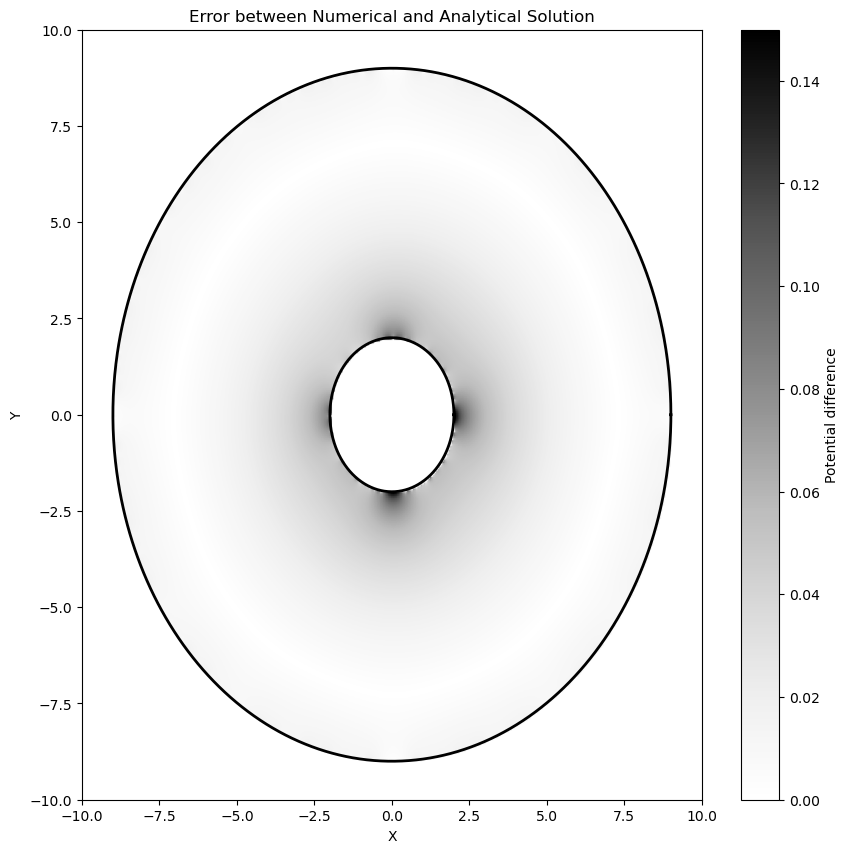

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def analy(ymax, xmax, dxy, V, r1, r2):
    x_vals = np.arange(-xmax, xmax, dxy)
    y_vals = np.arange(-ymax, ymax, dxy)
    x, y = np.meshgrid(x_vals, y_vals)
    
    r = np.sqrt(x**2 + y**2)
    mask_grid = (r >= r1) & (r <= r2)
    
    pot = np.zeros_like(r)
    pot[mask_grid] = (V * np.log(r1) - V * np.log(r[mask_grid])) / (np.log(r1) - np.log(r2))
    
    return pot

def poisson(ymax, xmax, dxy, V, r1, r2):
    x = np.arange(-xmax, xmax, dxy)
    y = np.arange(-ymax, ymax, dxy)
    X, Y = np.meshgrid(x, y)
    
    u = np.zeros_like(X)
    r = np.sqrt(X**2 + Y**2)

    # Create a mask for the region between r1 and r2
    mask = (r >= r1) & (r <= r2)
    outer=(r > r2)
    inner=(r < r1)
    
    """def shape(grid, what, where, howbig, Volt, SmalorBig):
        if what == "circle":
            r = np.sqrt((X - where[0])**2 + (Y - where[1])**2)
            if SmalorBig == "small":
                grid[r < howbig[0]] = Volt
            if SmalorBig == "big":
                grid[r < howbig[0]] = Volt"""
    
    def bounds(grid):
        # Apply boundary conditions using the mask 
        grid[outer] = V   # Set the outer region
        grid[inner] =0  # Set the inner region
        #shape(grid, "circle", [0, 0], [r2], V, "big")  # Outer boundary at r2
        #shape(grid, "circle", [0, 0], [r1], 0, "small")  # Inner boundary at r1

    bounds(u)  # Apply the boundary conditions initially
    
    diff = 1
    #max_iter = 5000  # Cap the maximum number of iterations to avoid long runs
    iteration = 0

    while diff > 1e-17 :
        u_new = u.copy()
        u_new[1:-1, 1:-1][mask[1:-1, 1:-1]] = 0.25 * (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2])[mask[1:-1, 1:-1]]

        # Convergence check
        diff = np.max(np.abs(u_new - u))
        #bounds(u_new)  # Reapply boundary conditions
        u = u_new
        #iteration += 1

    u[outer] = 0
    return u

# Parameters
ymax = 10  # Maximum y value
xmax = 10  # Maximum x value
r1 = 2  # Inner radius for the potential region
r2 = 9  # Outer radius for the potential region
dxy = 0.05  # Grid resolution (lower value results in more calculations)
V = 10

# Solve the Poisson equation
nupot = poisson(ymax, xmax, dxy, V, r1, r2)
analpot = analy(ymax, xmax, dxy, V, r1, r2)

# Calculate difference

ChangeInPot = np.abs(nupot- analpot)

# Plot the error
plt.figure(figsize=(10, 10))
plt.imshow(ChangeInPot, extent=(-xmax, xmax, -ymax, ymax), aspect='auto', cmap='Greys')

# Add circles at r1 and r2
theta_circle = np.linspace(0, 2 * np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)
x_circle2 = r2 * np.cos(theta_circle)
y_circle2 = r2 * np.sin(theta_circle)
    
plt.plot(x_circle1, y_circle1, color='black', linewidth=2, label=f'r = {r1} m')
plt.plot(x_circle2, y_circle2, color='black', linewidth=2, label=f'r = {r2} m')

plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Potential difference')
plt.title('Error between Numerical and Analytical Solution')
plt.show()

In [ ]:

import csv

# Create a sample 2D array (5x5 array)

# Write the array to a CSV file
with open('dif.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(ChangeInPot)
with open('num.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(nupot)
with open('ana.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(analpot)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def analy(ymax, xmax, dxy, V, r1, r2):
    x_vals = np.arange(-xmax, xmax, dxy)
    y_vals = np.arange(-ymax, ymax, dxy)
    x, y = np.meshgrid(x_vals, y_vals)
    
    r = np.sqrt(x**2 + y**2)
    mask_grid = (r >= r1) & (r <= r2)
    
    pot = np.zeros_like(r)
    pot[mask_grid] = (V * np.log(r1) - V * np.log(r[mask_grid])) / (np.log(r1) - np.log(r2))
    
    return pot

def poisson(ymax, xmax, dxy, V, r1, r2):
    x = np.arange(-xmax, xmax, dxy)
    y = np.arange(-ymax, ymax, dxy)
    X, Y = np.meshgrid(x, y)
    
    u = np.zeros_like(X)
    r = np.sqrt(X**2 + Y**2)

    # Create a mask for the region between r1 and r2
    mask = (r >= r1) & (r <= r2)
    outer=(r > r2)
    inner=(r < r1)
    
    """def shape(grid, what, where, howbig, Volt, SmalorBig):
        if what == "circle":
            r = np.sqrt((X - where[0])**2 + (Y - where[1])**2)
            if SmalorBig == "small":
                grid[r < howbig[0]] = Volt
            if SmalorBig == "big":
                grid[r < howbig[0]] = Volt"""
    
    def bounds(grid):
        # Apply boundary conditions using the mask
        grid[outer] = V   # Set the outer region
        grid[inner] =0  # Set the inner region
        #shape(grid, "circle", [0, 0], [r2], V, "big")  # Outer boundary at r2
        #shape(grid, "circle", [0, 0], [r1], 0, "small")  # Inner boundary at r1

    bounds(u)  # Apply the boundary conditions initially
    
    diff = 1
    #max_iter = 5000  # Cap the maximum number of iterations to avoid long runs
    iteration = 0

    while diff > 1e-7 :
        u_new = u.copy()
        for i in range(1, u.shape[0] - 1):  # Iterate over each row
            for j in range(1, u.shape[1] - 1):  # Iterate over each column
                if mask[i, j]:
                    u_new[i, j] = 0.25 * (u[i + 1, j] + u[i - 1, j] + u[i, j + 1] + u[i, j - 1])

        # Convergence check
        diff = np.max(np.abs(u_new - u))
        #bounds(u_new)  # Reapply boundary conditions
        u = u_new
        #iteration += 1

    u[outer] = 0
    return u

# Parameters
ymax = 10  # Maximum y value
xmax = 10  # Maximum x value
r1 = 2  # Inner radius for the potential region
r2 = 9  # Outer radius for the potential region
dxy = 0.05  # Grid resolution (lower value results in more calculations)
V = 10

# Solve the Poisson equation
nupot = poisson(ymax, xmax, dxy, V, r1, r2)
analpot = analy(ymax, xmax, dxy, V, r1, r2)

# Calculate difference

ChangeInPot = np.abs(nupot- analpot)

# Plot the error
plt.figure(figsize=(10, 10))
plt.imshow(ChangeInPot, extent=(-xmax, xmax, -ymax, ymax), aspect='auto', cmap='Greys')

# Add circles at r1 and r2
theta_circle = np.linspace(0, 2 * np.pi, 1000)
x_circle1 = r1 * np.cos(theta_circle)
y_circle1 = r1 * np.sin(theta_circle)
x_circle2 = r2 * np.cos(theta_circle)
y_circle2 = r2 * np.sin(theta_circle)
    
plt.plot(x_circle1, y_circle1, color='black', linewidth=2, label=f'r = {r1} m')
plt.plot(x_circle2, y_circle2, color='black', linewidth=2, label=f'r = {r2} m')

plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Potential difference')
plt.title('Error between Numerical and Analytical Solution')
plt.show()